# Building a Euribor Curve - Interpolation Analysis - Simple Case

We build an Ibor single-curve and examine different interpolation choices for a simple curve.

This follows:

https://quant.stackexchange.com/questions/53904/monotonic-cubic-spline-interpolation-quantlib-python?rq=1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *

####################################################################
#  FINANCEPY BETA Version 0.350 - This build: 30 Apr 2024 at 21:20 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [3]:
value_dt = Date(12, 5, 2020)

## Building the Single Curve

Build the Ibor Curve

In [4]:
cal = CalendarTypes.TARGET

depoDCCType = DayCountTypes.ACT_360
depos = []
spot_days = 0
settle_dt = value_dt.add_weekdays(spot_days)
depo = IborDeposit(settle_dt, "6M", -0.114/100.0, depoDCCType, cal_type=cal); depos.append(depo)
fraDCCType = DayCountTypes.ACT_360

fras = []
fra = IborFRA(settle_dt.add_tenor("6M"), "6M", -0.252/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("12M"), "6M", -0.306/100.0, fraDCCType, cal_type=cal); fras.append(fra)

swaps = []
swap_type = SwapTypes.PAY
fixed_dcc_type = DayCountTypes.THIRTY_E_360_ISDA
fixed_freqType = FrequencyTypes.ANNUAL

swap = IborSwap(settle_dt, "2Y", swap_type, -0.325/100.0, fixed_freqType, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "3Y", swap_type, -0.347/100.0, fixed_freqType, fixed_dcc_type, cal_type=cal); swaps.append(swap)

iborDepos = depos.copy()
iborFras = fras.copy()
ibor_swaps = swaps.copy()

In [5]:
iborCurves = {}
for interp_type in InterpTypes:
    iborCurve = IborSingleCurve(value_dt, iborDepos, iborFras, ibor_swaps, interp_type)
    iborCurves[interp_type] = iborCurve

Set up a list of dates

In [6]:
grid_dts = []
dt = Date(12, 5, 2020); grid_dts.append(dt)
dt = dt.add_tenor("6M"); grid_dts.append(dt)
dt = dt.add_tenor("6M"); grid_dts.append(dt)
dt = dt.add_tenor("6M"); grid_dts.append(dt)
dt = dt.add_tenor("6M"); grid_dts.append(dt)
dt = dt.add_tenor("12M"); grid_dts.append(dt)

In [7]:
print("              ", end="")

for interp in InterpTypes:
    print("%13s "% interp.name[0:15], end="")
print("")
    
for dt in grid_dts:
    print("%12s"% dt, end="")
    for interp in InterpTypes:
        iborCurve = iborCurves[interp]
        df = iborCurve.df(dt) / iborCurve.df(settle_dt)
        print("%15.7f "% (df), end="")
    print("")

              FLAT_FWD_RATES LINEAR_FWD_RATE LINEAR_ZERO_RAT FINCUBIC_ZERO_R NATCUBIC_LOG_DI NATCUBIC_ZERO_R PCHIP_ZERO_RATE PCHIP_LOG_DISCO 
 12-MAY-2020      1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000 
 12-NOV-2020      1.0005814       1.0005814       1.0005814       1.0005808       1.0005803       1.0005808       1.0005814       1.0005808 
 12-MAY-2021      1.0018508       1.0018508       1.0018508       1.0018480       1.0018504       1.0018514       1.0018526       1.0018509 
 12-NOV-2021      1.0034201       1.0034201       1.0034201       1.0034129       1.0034160       1.0034182       1.0034203       1.0034189 
 12-MAY-2022      1.0065272       1.0065272       1.0065272       1.0065215       1.0065289       1.0065295       1.0065347       1.0065323 
 12-MAY-2023      1.0104754       1.0104754       1.0104754       1.0104754       1.0104754       1.0104754       1.0104755       1.0104754 


This agrees perfectly with QL.

Now shift the dates and you see the different impact of the different interpolation schemes.

In [8]:
shiftedDates = []
for dt in grid_dts:
    shiftedDates.append(dt.add_tenor("15D"))

In [9]:
print("              ", end="")

for interp in InterpTypes:
    print("%8s "% interp.name[0:13], end="")
print("")
    
for dt in shiftedDates:
    print("%8s "% dt, end="")
    for interp in InterpTypes:
        iborCurve = iborCurves[interp]
        df = iborCurve.df(dt) / iborCurve.df(settle_dt)
        print("%12.6f "% (df), end="")
    print("")

              FLAT_FWD_RATE LINEAR_FWD_RA LINEAR_ZERO_R FINCUBIC_ZERO NATCUBIC_LOG_ NATCUBIC_ZERO PCHIP_ZERO_RA PCHIP_LOG_DIS 
27-MAY-2020     1.000047     1.000047     1.000047     1.000047     1.000031     1.000047     1.000047     1.000021 
27-NOV-2020     1.000685     1.000633     1.000659     1.000650     1.000665     1.000650     1.000634     1.000651 
27-MAY-2021     1.001978     1.001961     1.001964     1.001968     1.001954     1.001972     1.001971     1.001965 
27-NOV-2021     1.003672     1.003559     1.003637     1.003605     1.003625     1.003608     1.003603     1.003607 
27-MAY-2022     1.006693     1.006788     1.006687     1.006785     1.006777     1.006802     1.006705     1.006736 
27-MAY-2023     1.010638     1.010633     1.010621     1.010625     1.010592     1.010552     1.010619     1.010569 


This shows that the interpolations do not match once we are off the grid times.

## Curve Shape Analysis

Look at short end

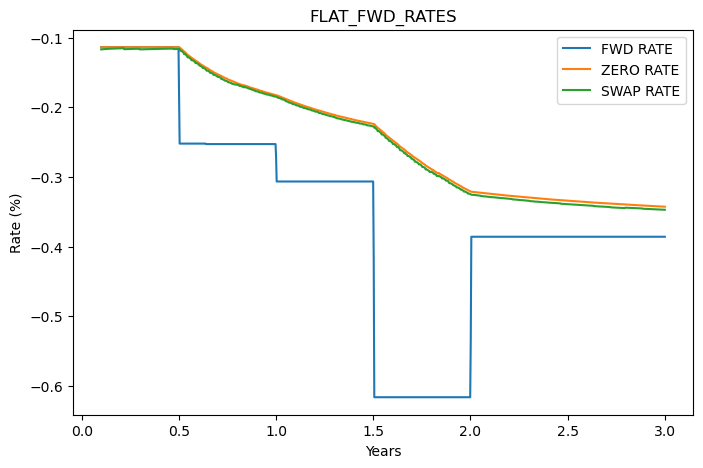

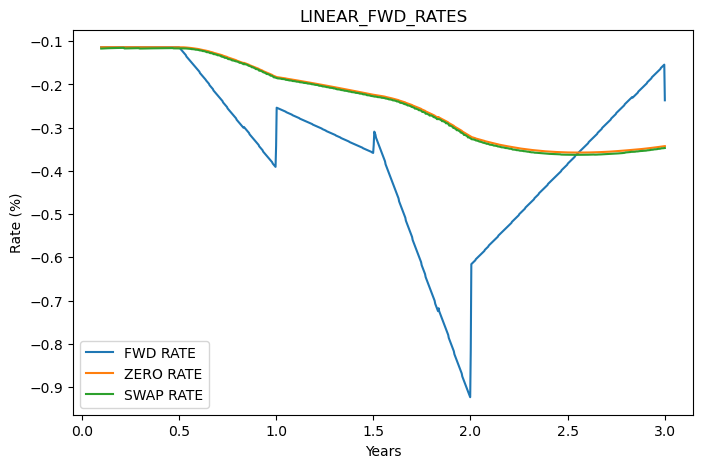

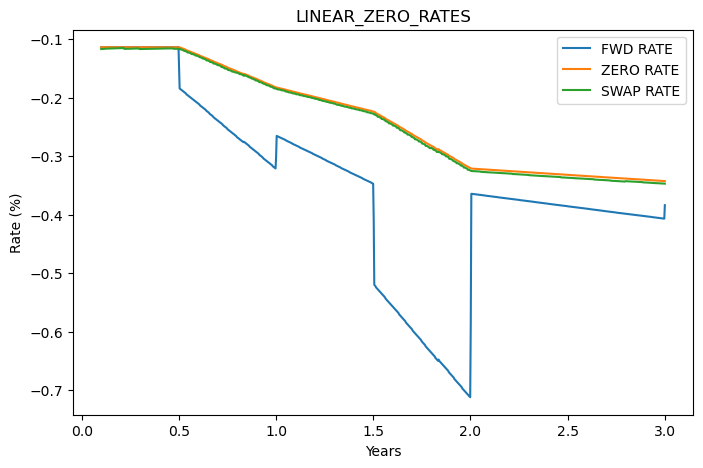

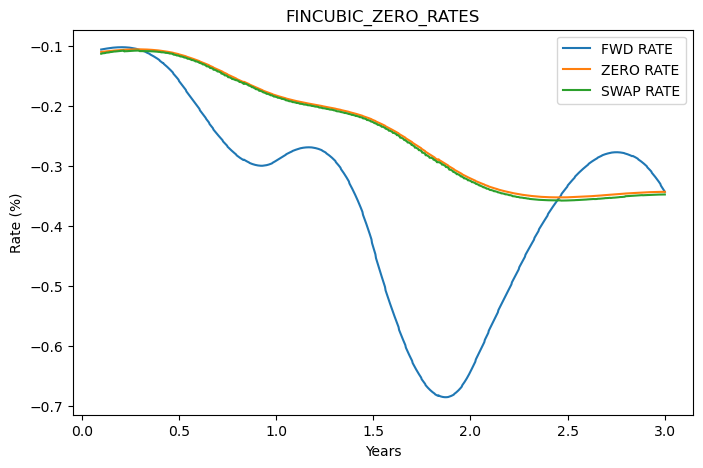

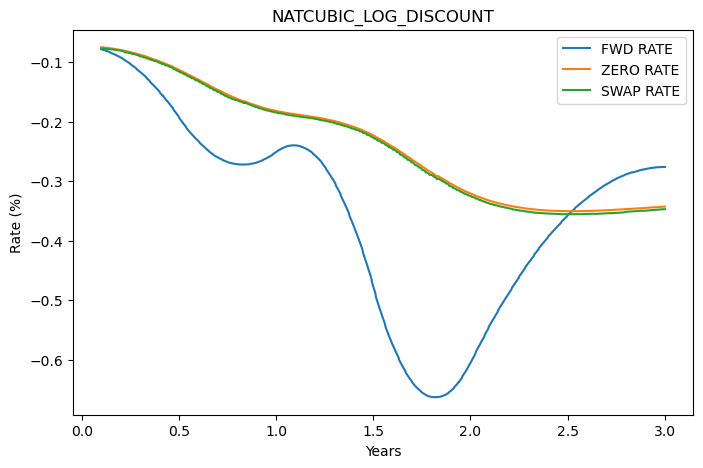

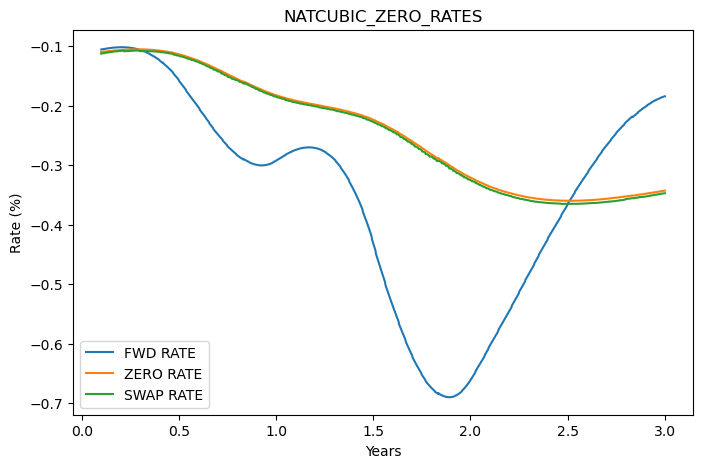

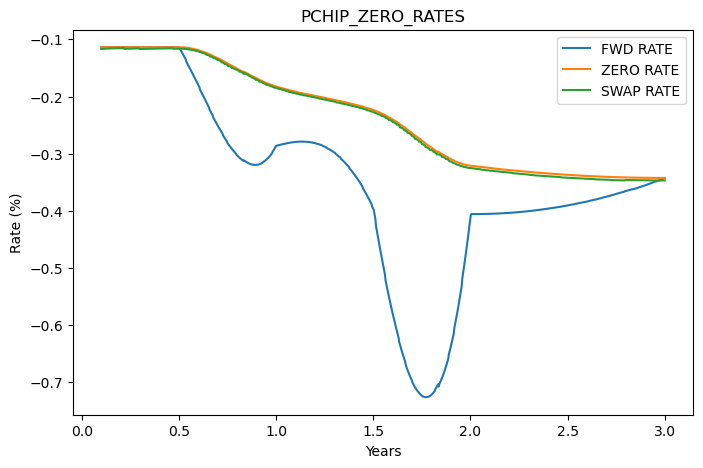

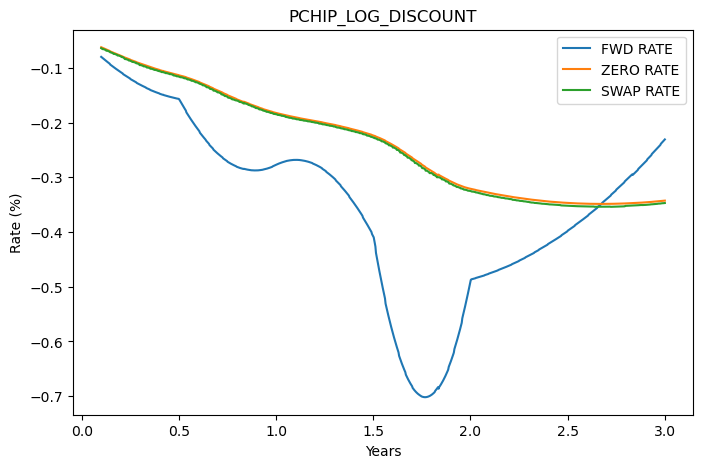

In [10]:
years = np.linspace(0.1, 3, 1000)
plotDates = settle_dt.add_years(years)

for interp_type in InterpTypes:

    plt.figure(figsize=(8,5))
    iborCurve = iborCurves[interp_type]
    iborCurveFwdRate = iborCurve.fwd_rate(plotDates, "1D")
    iborCurveZeroRate = iborCurve.zero_rate(plotDates)
    iborCurveSwapRate = iborCurve.swap_rate(settle_dt, plotDates)
    
    plt.plot(years, iborCurveFwdRate*100.0, label="FWD RATE")
    plt.plot(years, iborCurveZeroRate*100.0, label="ZERO RATE")
    plt.plot(years, iborCurveSwapRate*100.0, label="SWAP RATE")

    plt.title(interp_type.name)
    plt.xlabel("Years")
    plt.ylabel("Rate (%)")
    plt.legend();

Copyright (c) Dominic O'Kane 2020